# Raw Data - Per Patient Grouping EDA
(Zach Werkhoven)




<br>
The native structure of the ADNI data is a longitudinal form with one entry per visit, with each visit having an associated visit vode. Ultimately we want a data set with one entry per patient. An important decision will be determining how to split up the data. The purpose of this notebook is to explore methods of building a per patient data set.

**Import libraries**

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# import custom dependencies
from ADNI_utilities import define_terms, describe_meta_data, paths_with_ext, append_meta_cols

## Import data

The data used in this notebook will be a combination of raw ADNI data files previously cleaned and curated for this project. The data included falls into three categories:

**Biomarkers** (discussed in detail in `biomarker_EDA.ipynb`)
- ApoE gene data `apoe_clean.csv`
- Amyloid-beta, Tau, and pTau levels measured from cerebral spinal fluid `csf_clean.csv`
- Laboratory chemical screenings of patient blood and urine `lab_clean.csv`

**Medical History** (discussed in detail in `medical_history_EDA.ipynb`)
- neurological exams `neuroexams_clean.csv`
- general medical history `medhist_clean.csv`
- baseline health assessment `bls_symptoms.csv`
- vital signs measurments `vitals.csv`

**Subject Characteristics** (discussed in detail in `sub_characteristics.ipynb`)
- family history of dementia `famhist_clean.csv`
- demographics `demographics_clean.csv`

**Neuropsychological Assessments** (discussed in detail in `neuropsych_scores.ipynb`)
- geriatric depression scale `depression_clean.csv`
- mini-mental state exam `mmse_clean.csv`
- modified hachinski ischemia exam `mhach_clean.csv`

**Diagnostic Data** (discussed in detail in `Response_var_EDA.ipynb`)
- patient diagnoses including, but not limited to, Alzheimer's diagnosis `diagnosis_clean.csv`

In [2]:
# import adni dictionary
apo_dict = pd.read_csv("../data/Biomarker Data/APOERES_DICT.csv")

## Data Grouping

**Breakdown by VISCODE**

One possibility for aggregating the data is to take the first baseline (code: `bl`) visit for each patient from each data set. We can look at the breakdown of the data by `VISCODE` to see if this approach is viable.

In [3]:
# function that returns the number of records per patient from a dataframe
def patient_num_records(df):
    
    # get indices grouped by patient
    n_measurements = df.groupby("RID").apply(lambda x: x.shape[0])
    
    return(n_measurements)

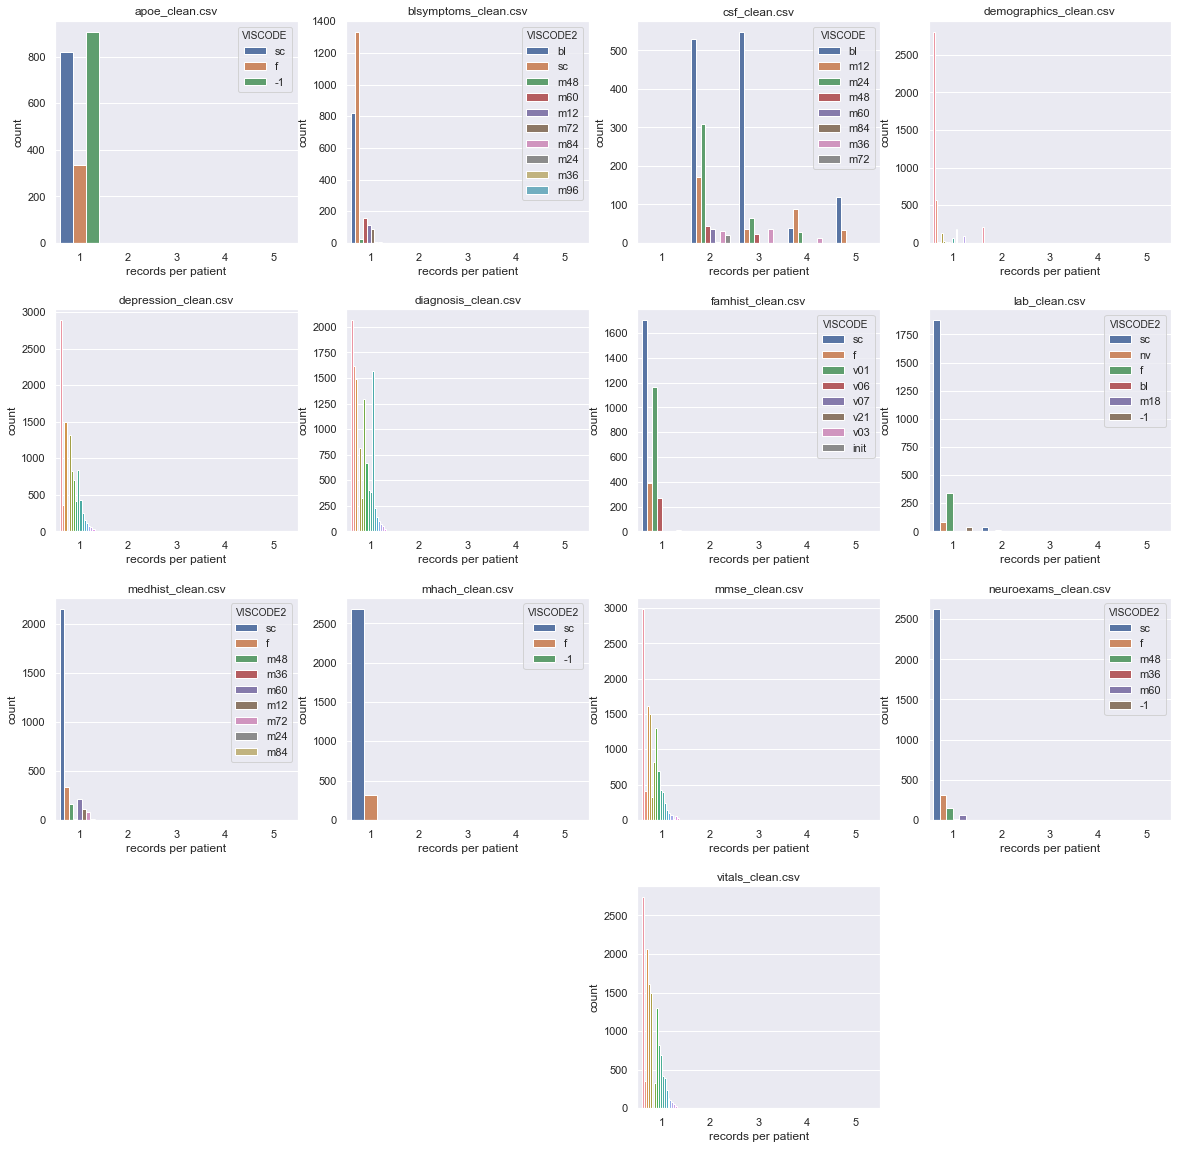

In [5]:
# define group and bins
grp = "VISCODE2"
bins = np.arange(1,7,1)
nbins = bins.shape[0]-1

# get data paths
csv_paths = paths_with_ext(directory="../data/Cleaned/")

# configure subplots
nrows = np.ceil(np.sqrt(len(csv_paths)))
ncols = np.ceil(len(csv_paths)/nrows)

# iterate over dataframes
plt.figure(figsize=(20,20))

for i, path in enumerate(csv_paths):
    
    # read in current dataframe
    df = pd.read_csv(path, low_memory=False)
    
    # create subplot for histogram of each df
    if "VISCODE2" in df.columns:
        grp="VISCODE2"
    elif "VISCODE" in df.columns:
        grp = "VISCODE"
    else:
        grp = False
        
    if grp:
        by_viscode = df.groupby(grp)
        records_per_viscode = by_viscode.apply(patient_num_records)

        # get viscodes from df
        viscodes = df[grp].dropna().unique()
        nv = viscodes.shape[0]
        vc = np.tile(viscodes,nbins)
        tmp_counts = np.zeros(viscodes.shape[0]*nbins)
        tmp_n = np.tile(np.arange(1,nbins+1,1).reshape(-1,1),nv).reshape(-1,nv).flatten()
        tmp_df = pd.DataFrame(data=np.vstack((vc,tmp_n,tmp_counts)).T, columns=[grp,"records","count"])

        plt.subplot(nrows,ncols,i+1)
        for j,code in enumerate(viscodes):

            # count num in each category
            tmp_df.loc[tmp_df[grp]==code,'count'] = np.histogram(records_per_viscode[code].values, bins)[0]

        # plot histogram
        sns.barplot(x="records", y="count", hue=grp, data=tmp_df)    
        plt.xlabel("records per patient")
        plt.ylabel("count")
        plt.title("{}".format(os.path.basename(path)))

        # display legend there are few than 10 unique codes
        if viscodes.shape[0] > 10:
            ax = plt.gca()
            ax.get_legend().set_visible(False)
    
    
plt.subplots_adjust(hspace=0.3)

We can see from the plots above that not all data sets will have a `bl` visit or will only be sparsely represented. Additionally, some data sets will have multiple `bl` records for each patient. We will have to use another strategy to aggregate the data.

**Records per patient**

With the ultimate goal being to create a data set with the format of one entry per patient, we will need to find approaches of collapsing the various measurements from each visit for each patient into a single entry. With this goal in mind, it should be helpful to look at the distribution of number of entries per patient for each data set.

Plot the distribution of entry number per patient for each dataframe

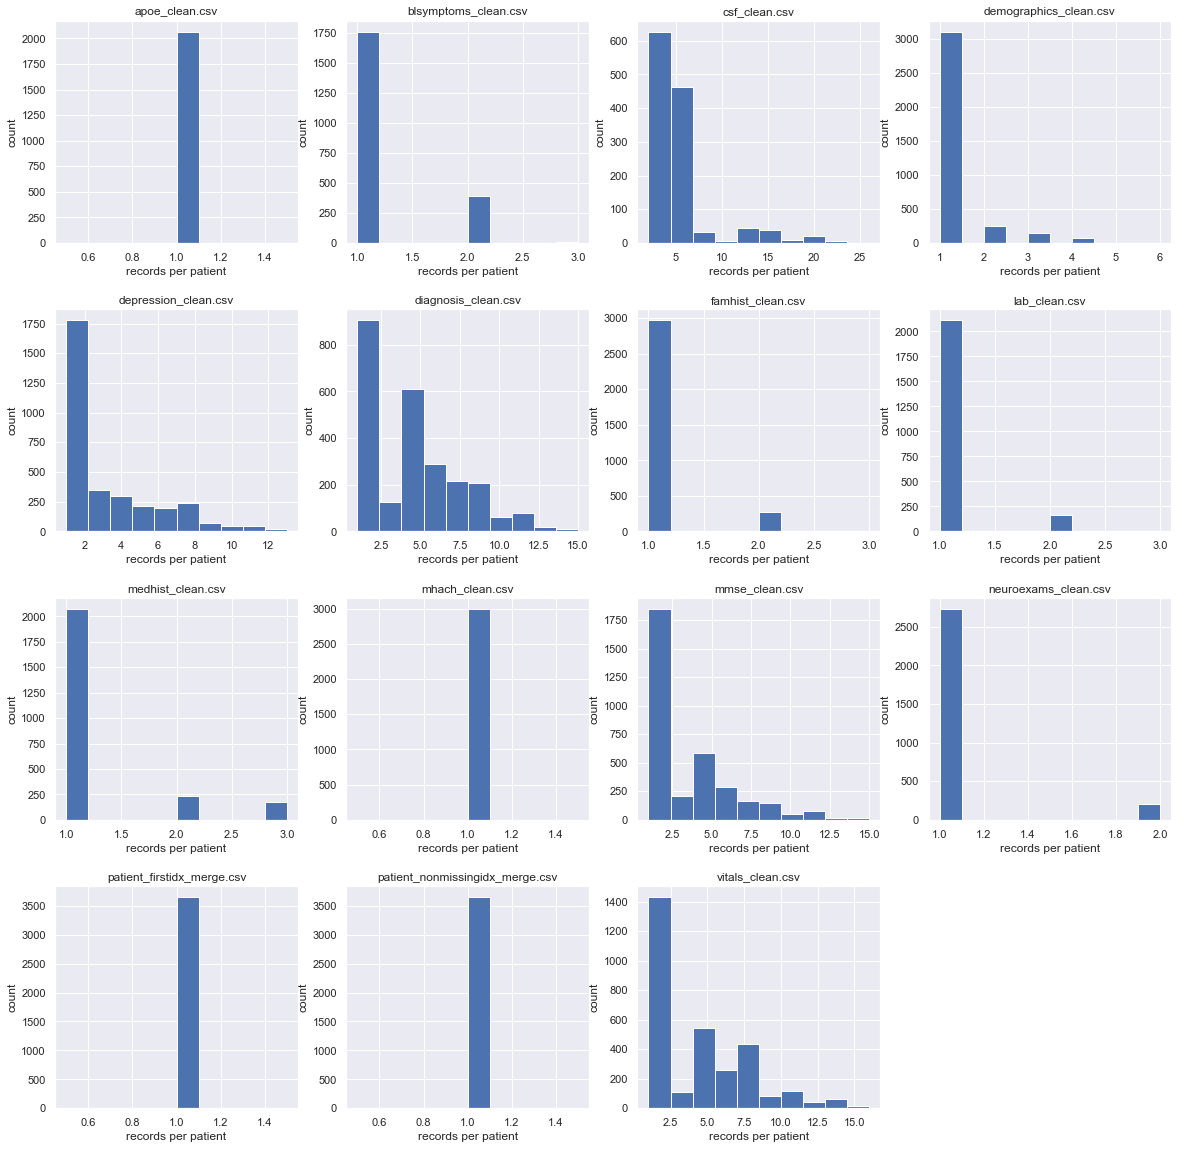

In [6]:
# iterate over dataframes
plt.figure(figsize=(20,20))
for i, path in enumerate(csv_paths):
    
    # read in current dataframe
    df = pd.read_csv(path, low_memory=False)
    
    # get number of records per patient
    n = patient_num_records(df)
    
    # plot histogram of results
    plt.subplot(nrows,ncols,i+1)
    plt.hist(n)
    plt.xlabel("records per patient")
    plt.ylabel("count")
    plt.title(os.path.basename(path))
    
plt.subplots_adjust(hspace=0.3)

As we can see the distribution of number of records per patient varies quite a lot. There are many different approaches we could take to compile a single entry. Simple strategies include:

1. Take the first entry per patient
2. Build the most complete entry for each patient (taking the first non-missing entry for each patient and feature)
3. Take per patient average for numeric data or per patient mode for categorical data

For data sets with only a single entry per patient, we only have one option: take the first and only record for each patient. We can also see that even in data sets where multiple entries per patient are possible, only a subset of the patients have multiple entries. For those reasons, I prefer approaches that take a single measurement per patient per feature, to make the measurements more comparable across patients. This leaves the first two strategies above.

To assess whether the strategy of building a most complete entry is viable, we should see if patients with missing values in the first entry have the values filled in other entries. One way to compare this two approaches is to define functions to build entries both ways and profile missingness in the resulting data set.

In [111]:
# define a function to extract the index-th entry for each patient from a datafame(df)
def patient_ith_entry(df, index=0):
    
    # group by patient ID
    by_RID = df.groupby("RID")
    
    # extract the df index for the index-th row for each patient
    entry_idx = by_RID.apply(lambda x: x.iloc[index]["Unnamed: 0"]).values
    entry_dat = df.iloc[entry_idx]
    entry_dat.set_index("RID", inplace=True)
    return(entry_dat, entry_idx)

In [116]:
# define a function to extract the first non-nan entry for each patient and feature
def patient_first_nonmissing_entry(df, missing_val=-1, index=0):
    
    # group by RID
    by_RID = df.groupby("RID")
    
    # define function to extract first non-missing val from series
    if np.isnan(missing_val):
        get_first_nonmissing = lambda y: y.loc[~y.isna()].iloc[0] if any(~y.isna()) else missing_val
    else:
        get_first_nonmissing = lambda y: y.loc[y!=missing_val].iloc[0] if any(y!=missing_val) else missing_val
        
    # for each RID grouping, apply function to each column
    by_nonmissing = by_RID.apply(lambda x: x.apply(get_first_nonmissing))
    return(by_nonmissing.drop(columns="RID", axis=1))

Now populate two per patient dataframes using the above methods and compare the amount of missingness between the two by plotting the number of missing values in each column. Display the difference in number missing between the two strategies.

FileNotFoundError: File b'../data/Cleaned/patient_firstidx_merge.csv' does not exist

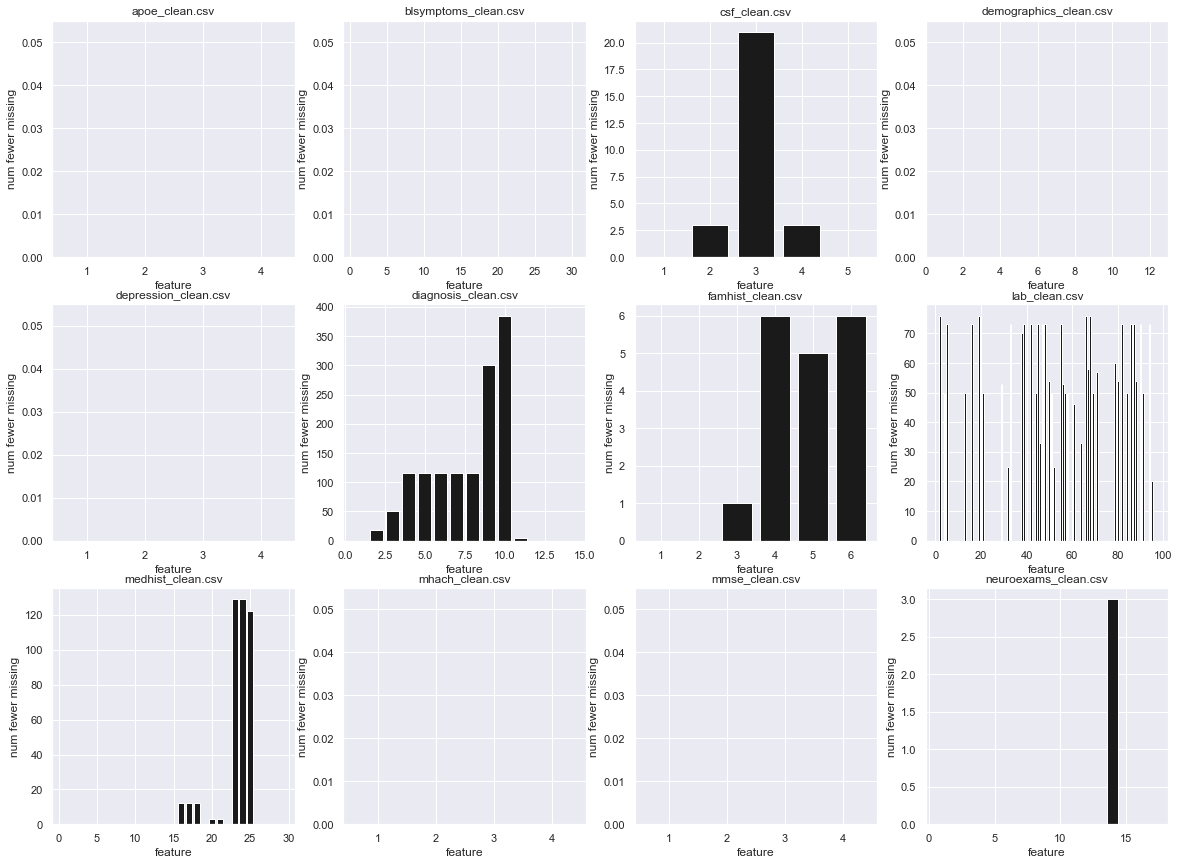

In [117]:
# initialize placeholders for new dataframes
first_idx_dfs = []
nonmissing_dfs = []
missing_value = -1

# iterate over dataframes
plt.figure(figsize=(20,20))
for i, path in enumerate(csv_paths):
    
    # read in current dataframe
    df = pd.read_csv(path, low_memory=False)
    
    # extract first entry
    RID_df, _ = patient_ith_entry(df)
    first_idx_dfs.append(RID_df)
    nmiss_first = first_idx_dfs[i].apply(lambda x: np.sum(x==missing_value))

    # extract first non-missing entries
    nonmissing_dfs.append(patient_first_nonmissing_entry(df))
    nmiss_non = nonmissing_dfs[i].apply(lambda x: np.sum(x==missing_value))
    
    # plot missingness difference between the two grouping methods
    plt.subplot(nrows,ncols,i+1)
    plt.bar(np.arange(1,nmiss_first.shape[0]+1,1), nmiss_first.values - nmiss_non.values, color='k')
    plt.ylim(0,plt.ylim()[1])
    plt.xlabel("feature")
    plt.ylabel("num fewer missing")
    plt.title(os.path.basename(path));
    
plt.subplots_adjust(hspace=0.3)

In at least one data set (lab data), taking the first non-missing value recovers some additional data for a subset of the features, although it's not a huge effect compared to the number of patients in the data set ($\approx$3000). The penalty we pay for this additional data is that the data is more likely to be from diverse time points throughout the study.

**Final Diagnosis**

For the purposes of our analysis, we will likely want to track the change in a patient's diagnosis from the baseline assessment to the final visit. We can use the method described above to take the patient entry at a particular index. This time we'll use `index = -1` to take the last entry for each patient. We'll also return the row index within the dataframe for both the first and the last entry. This will allow us to identify patients with only a single diagnosis (ie. the first and last index are the same). 

In [118]:
# creat new diagnosis dataframes extracting the first and last entries per patient
dx_df = pd.read_csv("../data/Cleaned/diagnosis_clean.csv", low_memory=False)
first_dx_df, first_dx_df_rows = patient_ith_entry(dx_df, index=0)
last_dx_df, last_dx_df_rows = patient_ith_entry(dx_df, index=-1)

# create new features: baseline diagnosis, final diagnosis
bl_dx = first_dx_df.DXCOMB.values
final_dx = last_dx_df.DXCOMB.values

# set final diagnosis to missing if patient only has one diagnosis
final_dx[first_dx_df_rows == last_dx_df_rows] = -1

# use first and last diagnosis to create new feature: change in diagnosis (baseline to final)
change_dx = (final_dx-1)*3 + bl_dx
change_dx[change_dx<1] = -1

In [119]:
# add features to per patient diagnosis df
pd.options.mode.chained_assignment = None  # default='warn'
first_dx_df["DX_BL"] = pd.Series(bl_dx, index=first_dx_df.index)
first_dx_df["DX_FINAL"] = pd.Series(final_dx, index=first_dx_df.index)
first_dx_df["DX_CHANGE"] = pd.Series(change_dx, index=first_dx_df.index)
first_dx_df.head()

# get the index of the per patient diagnosis dataframe and replace with the dataframe
# containing our new featuress
dx_df_idx = [i for i, path in enumerate(csv_paths) if "diagnosis" in path]
first_idx_dfs[dx_df_idx[0]] = first_dx_df

## Combining the data

Now we can build per patient datasets by concatenating the dataframes constructed using the methods above. We'll start by combining the data aggregated by the first index method.

**First Entry per Patient**

In [120]:
# intialize dataframe empty placeholder
patient_first_idx_df = pd.DataFrame()

# record the data type of each column (we'll need it later)
all_dtypes = np.array([])

# iterate over dataframes
for i, df in enumerate(first_idx_dfs):
    
    # get columns for current df
    new_cols = df.columns
    
    # remove duplicate columns
    new_cols = list(set(new_cols)-set(patient_first_idx_df))
    
    # drop meta data and bad columns
    new_cols = list(set(new_cols)-set(["RID","Unnamed: 0","VISCODE","VISCODE2"]))
    
    # generate per patient dataframe from df
    tmp_df = df[new_cols]
    all_dtypes = np.append(all_dtypes,df[new_cols].dtypes.values)

    # add to patient df
    patient_first_idx_df = pd.concat((patient_first_idx_df, tmp_df), axis=1)


In [121]:
# inspect the header of the new per patient dataframe
patient_first_idx_df.head()

,APGEN1,APGEN2,BCVOMIT,BCENERGY,BCHDACHE,BCURNFRQ,BCINSOMN,BCDROWSY,BCURNDIS,BCMUSCLE,...,NXFINGER,NXABNORM,NXNERVE,NXTREMOR,NXGAIT,NXOTHER,NXPLANTA,NXSENSOR,NXTENDON,NXHEEL
RID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,3.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0


The concatenation was successful, but in the process of concatentating, pandas automatically fills missing values in the full data set with `NaN`. The missing values can easily be converted back to `-1` with `pd.replace`, but this process of missing value filling has also converted the data types of all columns to `float64`. We will want to use the data types to distinguish categorical from continuous features. We will need to use the dtypes of the source dataframes to convert each of the columns back to the appropriate data type.

In [122]:
# convert missing values to -1
patient_first_idx_df.replace({np.nan:-1, -4:-1}, inplace=True)

# intialize dictionary {column: dtype,..} to set data types
dtype_dict = dict.fromkeys(patient_first_idx_df.columns.values)
for key, val in zip(patient_first_idx_df.columns.values,all_dtypes):
    dtype_dict[key] = val

# convert dtypes
patient_first_idx_df = patient_first_idx_df.astype(dtype_dict)

Inspect the header to check the conversion:

In [123]:
patient_first_idx_df.head()

,APGEN1,APGEN2,BCVOMIT,BCENERGY,BCHDACHE,BCURNFRQ,BCINSOMN,BCDROWSY,BCURNDIS,BCMUSCLE,...,NXFINGER,NXABNORM,NXNERVE,NXTREMOR,NXGAIT,NXOTHER,NXPLANTA,NXSENSOR,NXTENDON,NXHEEL
RID,,,,,,,,,,,,,,,,,,,,,
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3,3,1,1,1,2,1,1,1,2,...,1,1,1,1,1,1,1,1,1,1
3,3,4,1,1,1,1,2,1,1,2,...,1,1,1,1,1,1,1,1,1,1
4,3,3,1,1,1,1,1,1,2,2,...,1,1,1,1,1,1,1,1,1,1
5,3,3,1,1,1,2,1,1,1,2,...,1,1,1,1,1,1,1,2,1,1


**First Non-Missing Entry per Patient**

Now we can do the same for the per patient dataframe assembled with the first non-missing entry method.

In [124]:
# intialize dataframe empty placeholder
patient_nonmissing_df = pd.DataFrame()

# record the data type of each column
all_dtypes = np.array([])

# iterate over dataframes
for i, df in enumerate(nonmissing_dfs):
    
    # get columns for current df
    new_cols = df.columns
    
    # remove duplicate columns
    new_cols = list(set(new_cols)-set(patient_nonmissing_df))
    
    # drop meta data and bad columns
    new_cols = list(set(new_cols)-set(["RID","Unnamed: 0","VISCODE","VISCODE2"]))
    
    # generate per patient dataframe from df
    tmp_df = df[new_cols]
    all_dtypes = np.append(all_dtypes,df[new_cols].dtypes.values)
    
    # add to patient df
    patient_nonmissing_df = pd.concat((patient_nonmissing_df, tmp_df), axis=1)


In [125]:
# convert missing values to -1
patient_nonmissing_df.replace({np.nan:-1, -4:-1}, inplace=True)

# intialize dictionary {column: dtype,..} to set data types
dtype_dict = dict.fromkeys(patient_nonmissing_df.columns.values)
for key, val in zip(patient_nonmissing_df.columns.values,all_dtypes):
    dtype_dict[key] = val

# convert dtypes
patient_nonmissing_df = patient_nonmissing_df.astype(dtype_dict)

In [126]:
# inspect the header
patient_nonmissing_df.head()

,APGEN1,APGEN2,BCVOMIT,BCENERGY,BCHDACHE,BCURNFRQ,BCINSOMN,BCDROWSY,BCURNDIS,BCMUSCLE,...,NXFINGER,NXABNORM,NXNERVE,NXTREMOR,NXGAIT,NXOTHER,NXPLANTA,NXSENSOR,NXTENDON,NXHEEL
RID,,,,,,,,,,,,,,,,,,,,,
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3,3,1,1,1,2,1,1,1,2,...,1,1,1,1,1,1,1,1,1,1
3,3,4,1,1,1,1,2,1,1,2,...,1,1,1,1,1,1,1,1,1,1
4,3,3,1,1,1,1,1,1,2,2,...,1,1,1,1,1,1,1,1,1,1
5,3,3,1,1,1,2,1,1,1,2,...,1,1,1,1,1,1,1,2,1,1


We can confirm that there is a unique entry for each patient and a unique list of columns by comparing the unique entries of each to the full shape of the dataframe. Doing so confirms that all columns and RIDs are unique.

In [127]:
# confirm that there is indeed only one entry for each patient
print(patient_nonmissing_df.shape)
print(patient_nonmissing_df.index.unique().shape)
print(patient_nonmissing_df.columns.unique().shape)

(3652, 193)
(3652,)
(193,)


## Save per Patient Formatted Data to File

With all the formatting and aggregation complete, it's a good idea to write the data to file as a convenient check-point we can revisit later.

In [128]:
patient_first_idx_df.to_csv("../data/Per_Patient/patient_firstidx_merge.csv")
patient_nonmissing_df.to_csv("../data/Per_Patient/patient_nonmissingidx_merge.csv")

**Deal with Missingness**



In [491]:
# throw away any column with only nans
all_missing_cols = pat_df.columns[np.isnan(pat_df.values).all(0)]
pat_df = pat_df.drop(columns=all_missing_cols, axis=1)

# throw away any row with nan in dx_comb
no_dx = pat_df.DXCOMB.isna()

# return df with rows dropped
pat_df = pat_df.drop(index=pat_df.loc[no_dx].index)

In [492]:
# compute mean of each numeric column with missing values
replace_cols = pat_df.drop(columns="RID", axis=1).columns
col_means = pat_df[replace_cols].apply(np.nanmean)
is_missing = pat_df[replace_cols].isna().values

#index each column and replace with column mean
for i,col in enumerate(replace_cols):
    pat_df.loc[is_missing[:,i],col] = col_means[i]

**Modeling**

Let's try to model the data with a decision tree model. We'll start by splitting the data.

In [496]:
pat_df["DXCOMB"] = pat_df.DXCOMB.astype(int)

In [600]:
train_df, test_df = train_test_split(pat_df, test_size=0.2)
x_train = train_df.drop(columns=["RID","DXCOMB"], axis=1)
y_train = train_df.DXCOMB
x_test = test_df.drop(columns=["RID","DXCOMB"], axis=1)
y_test = test_df.DXCOMB

Max Train Score at depth = 5
mean accuracy (test): 0.864


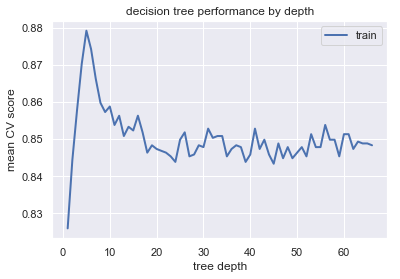

In [601]:
#define depths to test
depths = np.arange(1,pat_df.shape[1],1)
avg_train_score = np.empty(depths.shape, dtype=float)
avg_test_score = np.empty(depths.shape, dtype=float)

# fit decision tree at each depth and record accuracy
for i, depth in enumerate(depths):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=depth).fit(x_train,y_train)
    avg_train_score[i] = cross_val_score(clf, x_train, y_train, cv=5).mean()
    
plt.plot(depths, avg_train_score, c='b', lw=2, label="train")
ax = plt.gca()
ax.set_xlabel("tree depth")
ax.set_ylabel("mean CV score")
ax.legend()
ax.set_title("decision tree performance by depth");

# train clf at best depth and report accuracy
best_depth = depths[np.argmax(avg_train_score)]
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=best_depth).fit(x_train,y_train)
print("Max Train Score at depth = %i" % best_depth)
print("mean accuracy (test): {0:.3f}".format(cross_val_score(best_clf, x_test, y_test, cv=10).mean()))


In [602]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=3).fit(x_train,y_train)
print("mean accuracy (train): {0:.3f}".format(cross_val_score(tree, x_train, y_train, cv=10).mean()))
print("mean accuracy (train): {0:.3f}".format(cross_val_score(tree, x_test, y_test, cv=10).mean()))

mean accuracy (train): 0.858
mean accuracy (train): 0.882


In [603]:
# lets compare it to a bad model
np.histogram(pat_df.DXCOMB.values, bins=[1,2,3,4])[0]/pat_df.shape[0]

array([0.40015911, 0.4363564 , 0.16348449])

In [598]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [604]:
show_tree_structure(best_clf)

The binary tree structure has 31 nodes:

node 0: if X[:, 9] <= 0.992 then go to node 1, else go to node 30
  node 1: if X[:, 0] <= 157.000 then go to node 2, else go to node 17
    node 2: if X[:, 62] <= 74.950 then go to node 3, else go to node 10
      node 3: if X[:, 23] <= 65.250 then go to node 4, else go to node 7
        node 4: if X[:, 50] <= 158.500 then go to node 5, else go to node 6
          node 5: predict class 1
          node 6: predict class 1
        node 7: if X[:, 48] <= 61.000 then go to node 8, else go to node 9
          node 8: predict class 1
          node 9: predict class 3
      node 10: if X[:, 23] <= 62.150 then go to node 11, else go to node 14
        node 11: if X[:, 43] <= 37.500 then go to node 12, else go to node 13
          node 12: predict class 3
          node 13: predict class 3
        node 14: if X[:, 51] <= 10.700 then go to node 15, else go to node 16
          node 15: predict class 3
          node 16: predict class 1
    node 17: if X[:

In [606]:
# print columns in order of importance
splits = [9,0,16,62,23,12,48,43,41]
x_train.columns[splits]

Index(['DXMPTR1', 'ABETA', 'DXPARK', 'TAU', 'HMT15', 'DXMPTR4', 'RCT14',
       'PTAU', 'HMT96'],
      dtype='object')

According to this model, the best predictor is a self-reported memory complaint. 

**PCA**

Let's try some dimensionality reduction with PCA.

In [573]:
# first scale the data from range 0-1
scaler = MinMaxScaler()
scaler = scaler.fit(x_train)
scaled_train = scaler.transform(x_train)
scaled_test = scaler.transform(x_test)

In [589]:
# perform PCA on scaled data and store in new df
pca = PCA(n_components=x_train.shape[1])
pca.fit(scaled_train)

# transform data and store in new dataframe
columns = ['pc_%i' % i for i in range(x_train.shape[1])]
df_pca = pd.DataFrame(pca.transform(scaled_train), columns=columns, index=train_df.index)

# get design matrices for train and test
pca_x_train = df_pca.values
pca_x_test = pca.transform(scaled_test)

# store response var
df_pca["DX"] = y_train

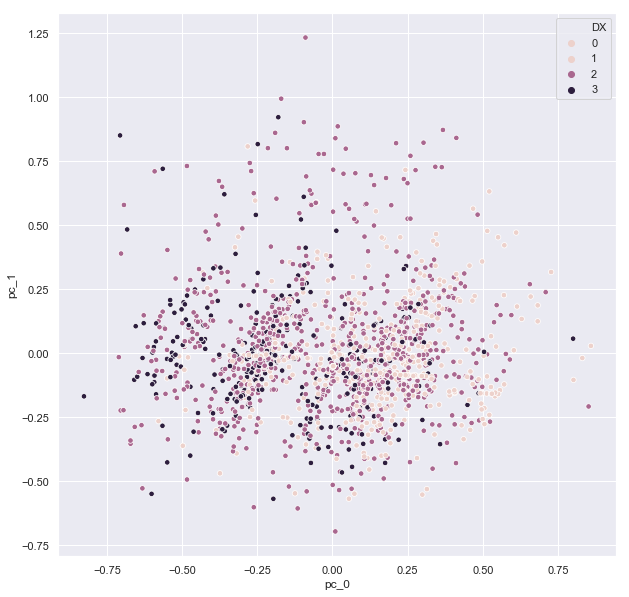

In [590]:
plt.figure(figsize=(10,10))
ax=sns.scatterplot(x="pc_0", y="pc_1", hue="DX", data=df_pca, s=30)

In [597]:
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=2).fit(pca_x_train,y_train)
print("mean accuracy (test): {0:.3f}".format(cross_val_score(best_clf, pca_x_test, y_test, cv=10).mean()))

mean accuracy (test): 0.722
